### Imports

In [ ]:
import string
import re
import numpy
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN, GRU, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/noEstructurado/TEXT/

/content/drive/MyDrive/noEstructurado/TEXT


### Lectura de los datos

 El primer paso es leer nuestros datos que están en el fichero 'data/spa.txt'.

 Tendremos que pre-procesarlos para quedarnos con una estructura de *numpy array* de dos dimensiones, creando pares de frases inglés-castellano.


In [ ]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("data/spa.txt")
es_en = to_lines(data)
es_en = array(es_en)

In [ ]:
es_en = numpy.array([el[0:2] for el in es_en])

In [ ]:
es_en.shape
# Memory constraints
# es_en = es_en[:50000,:]

(122936, 2)

### Text Pre-Processing

#### Limpieza del texto

Antes de utilizar los datos, tendremos que limpiarlos para que no tener caractereres no deseados.

En este caso, simplemente eliminaremos los signos de puntuación y llevaremos todos los caracteres a minúsculas.

In [ ]:
es_en

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
        'Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a la siguiente página encontrada por Google y espero encontrar algo menos irritante.'],
       ['If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.',
        'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y

In [ ]:
# Remove punctuation
es_en[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in es_en[:,0]]
es_en[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in es_en[:,1]]

In [ ]:
# convert to lowercase
for i in range(len(es_en)):
    es_en[i,0] = es_en[i,0].lower()
    
    es_en[i,1] = es_en[i,1].lower()

In [ ]:
es_en

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google and hope for something less irritating',
        'como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes simplemente voy a la siguiente página encontrada por google y espero encontrar algo menos irritante'],
       ['if you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la 

#### Text to Sequence Conversion

Los modelos Seq2Seq son aquellos que convierten una secuencia de entrada en otra distinta de salida, cambiando de dominio. De forma muy simplificada, estos modelos están compuestos por dos elementos básicos: el *encoder* y el *decoder*. 

Los pasos a realizar son (fuente: [keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html#:~:text=Sequence%2Dto%2Dsequence%20learning%20(,same%20sentences%20translated%20to%20French).)):
1. Encode the input sequence into state vectors.
2. Start with a target sequence of size 1 (just the start-of-sequence character).
3. Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character.
4. Sample the next character using these predictions (we simply use argmax).
5. Append the sampled character to the target sequence
6. Repeat until we generate the end-of-sequence character or we hit the character limit.

En este caso, la secuencia de entrada será una línea de texto en un idioma (castellano), y la salida será la traducción del mismo (al inglés).

Los *inputs* del modelo han de pasarse de caracteres a enteros de longitud fija, y lo que haremos será capturar las longitudes de las frases, vectorizar las frases utilizando el *Keras Tokenizer()*, y añadir *padding* de ceros para que todos los vectores tengan la misma longitud.

In [ ]:
# empty lists
eng_l = []
es_l = []

# populate the lists with sentence lengths
for i in es_en[:,0]:
    eng_l.append(len(i.split()))

for i in es_en[:,1]:
    es_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'es':es_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.es))

        eng  es
0         1   1
1         1   1
2         1   1
3         1   1
4         1   1
...     ...  ..
122931   34  42
122932   34  35
122933   43  44
122934   47  49
122935   47  53

[122936 rows x 2 columns]
47
53


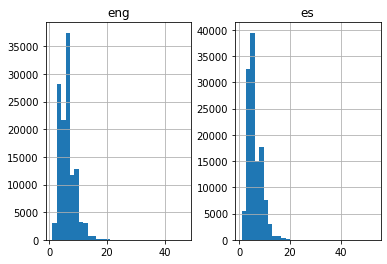

In [ ]:
length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(es_en[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 16
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13731


In [ ]:
# prepare Spanish tokenizer
es_tokenizer = tokenization(es_en[:, 1])
es_vocab_size = len(es_tokenizer.word_index) + 1

es_length = 16
print('Spanish Vocabulary Size: %d' % es_vocab_size)

Spanish Vocabulary Size: 27431


In [ ]:
print(es_tokenizer.word_counts)

OrderedDict([('ve', 229), ('vete', 39), ('vaya', 170), ('váyase', 8), ('hola', 22), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 3), ('¿quién', 607), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 3), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 12), ('continúa', 20), ('continúe', 8), ('corrí', 19), ('corría', 11), ('lo', 6921), ('intento', 34), ('¡he', 2), ('ganado', 38), ('¡oh', 9), ('no', 20563), ('tomátelo', 2), ('con', 4924), ('soda', 4), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 12), ('¡al', 3), ('ataque', 26), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 42), ('ahora', 1088), ('mismo', 561), ('id', 7), ('vayan', 24), ('ya', 1062), ('¡lo', 10), ('tengo', 2129), ('¿lo', 84), ('pillas', 2), ('¿entendiste', 10), ('él', 6993), ('corrió', 57), ('métete', 4), ('adentro', 4

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Construcción del modelo

Para crear el modelo dividiremos el set de datos en *Training* y *Test* (utilizaremos únicamente un 2% de *Test* dado que la predicción del modelo consume mucha RAM y con un tamaño de *Test* muy grande no entran las predicciones en memoria).

El primer paso será codificar las frases con las funciones definidas anteriormente.

Para esta práctica hemos definido 3 modelos distintos: RNN, GRU y LSTM, y compararemos los resultados obtenidos con ambos.

Utilizaremos _**sparse_categorical_crossentropy**_ como función de pérdidas para poder tener como entrada los vectores de features definidos y no tener que utilizar *one-hot encoding*.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(es_en, test_size=0.02, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(es_tokenizer, es_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   13    27 21334 ...     0     0     0]
 [  633   220    10 ...     0     0     0]
 [   23    39    84 ...     0     0     0]
 ...
 [   60   316  2401 ...     0     0     0]
 [    4   275   810 ...     0     0     0]
 [   19   119  1840 ...     0     0     0]]
120477
[[   8   46 2799 ...    0    0    0]
 [ 272   64   66 ...    0    0    0]
 [ 306  144  186 ...    0    0    0]
 ...
 [  74  470  836 ...    0    0    0]
 [   2  219   68 ...    0    0    0]
 [  17  156 1081 ...    0    0    0]]
120477


In [ ]:
# prepare validation data
testX = encode_sequences(es_tokenizer, es_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  22   55 4701 ...    0    0    0]
 [  11  164  244 ...    0    0    0]
 [   9  201    2 ...    0    0    0]
 ...
 [  34  226    9 ...    0    0    0]
 [5982  407 3342 ...    0    0    0]
 [   5 5015    3 ...    0    0    0]]
2459
[[  21   42 3163 ...    0    0    0]
 [ 161   35    3 ...    0    0    0]
 [   8    7  224 ...    0    0    0]
 ...
 [  26  233    7 ...    0    0    0]
 [  81 1377    6 ...    0    0    0]
 [   5 1688   24 ...    0    0    0]]
2459


In [ ]:
print(trainX.shape)
print(testY.shape)

(120477, 16)
(2459, 16)


In [ ]:
# build rnn model
def build_model_rnn(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    rnn = Sequential()
    rnn.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    rnn.add(SimpleRNN(units))
    rnn.add(RepeatVector(out_timesteps))
    rnn.add(SimpleRNN(units,return_sequences=True))
    rnn.add(Dense(out_vocab, activation='softmax'))
    return rnn

In [ ]:
# build gru model
def build_model_gru(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    gru = Sequential()
    gru.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    gru.add(GRU(units))
    gru.add(Dropout(0.2))
    gru.add(RepeatVector(out_timesteps))
    gru.add(GRU(units,return_sequences=True))
    gru.add(Dropout(0.2))
    gru.add(Dense(out_vocab, activation='softmax'))
    return gru

In [ ]:
# build NMT model
def build_model_lstm(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    lstm = Sequential()
    lstm.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    lstm.add(LSTM(units))
    lstm.add(RepeatVector(out_timesteps))    
    lstm.add(LSTM(units, return_sequences=True))
    lstm.add(Dense(out_vocab, activation='softmax'))
    return lstm

In [ ]:
#model = build_model_rnn(es_vocab_size, eng_vocab_size, es_length, eng_length, 128)
#model = build_model_gru(es_vocab_size, eng_vocab_size, es_length, eng_length, 128)
model = build_model_lstm(es_vocab_size, eng_vocab_size, es_length, eng_length, 128)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 128)           3511168   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 16, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 128)           131584    
_________________________________________________________________
dense (Dense)                (None, 16, 13731)         1771299   
Total params: 5,545,635
Trainable params: 5,545,635
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filename = 'model_lstm.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=20, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
753/753 [==============================] - 35s 37ms/step - loss: 3.3104 - val_loss: 2.4395

Epoch 00001: val_loss improved from inf to 2.43950, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 2/20
753/753 [==============================] - 26s 35ms/step - loss: 2.3730 - val_loss: 2.2555

Epoch 00002: val_loss improved from 2.43950 to 2.25550, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 3/20
753/753 [==============================] - 27s 35ms/step - loss: 2.2068 - val_loss: 2.1335

Epoch 00003: val_loss improved from 2.25550 to 2.13346, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 4/20
753/753 [==============================] - 26s 35ms/step - loss: 2.0789 - val_loss: 2.0296

Epoch 00004: val_loss improved from 2.13346 to 2.02960, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 5/20
753/753 [==============================] - 27s 35ms/step - loss: 1.9641 - val_loss: 1.9259

Epoch 00005: val_loss improved from 2.02960 to 1.92590, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 6/20
753/753 [==============================] - 27s 35ms/step - loss: 1.8482 - val_loss: 1.8546

Epoch 00006: val_loss improved from 1.92590 to 1.85456, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 7/20
753/753 [==============================] - 26s 35ms/step - loss: 1.7456 - val_loss: 1.7733

Epoch 00007: val_loss improved from 1.85456 to 1.77329, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 8/20
753/753 [==============================] - 26s 35ms/step - loss: 1.6679 - val_loss: 1.7137

Epoch 00008: val_loss improved from 1.77329 to 1.71370, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 9/20
753/753 [==============================] - 26s 35ms/step - loss: 1.5976 - val_loss: 1.6653

Epoch 00009: val_loss improved from 1.71370 to 1.66534, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 10/20
753/753 [==============================] - 27s 36ms/step - loss: 1.5308 - val_loss: 1.6265

Epoch 00010: val_loss improved from 1.66534 to 1.62649, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 11/20
753/753 [==============================] - 27s 36ms/step - loss: 1.4788 - val_loss: 1.5969

Epoch 00011: val_loss improved from 1.62649 to 1.59692, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 12/20
753/753 [==============================] - 27s 36ms/step - loss: 1.4229 - val_loss: 1.5750

Epoch 00012: val_loss improved from 1.59692 to 1.57504, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 13/20
753/753 [==============================] - 27s 36ms/step - loss: 1.3853 - val_loss: 1.5602

Epoch 00013: val_loss improved from 1.57504 to 1.56023, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 14/20
753/753 [==============================] - 27s 36ms/step - loss: 1.3426 - val_loss: 1.5317

Epoch 00014: val_loss improved from 1.56023 to 1.53173, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 15/20
753/753 [==============================] - 27s 36ms/step - loss: 1.3041 - val_loss: 1.5181

Epoch 00015: val_loss improved from 1.53173 to 1.51812, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 16/20
753/753 [==============================] - 27s 36ms/step - loss: 1.2742 - val_loss: 1.5049

Epoch 00016: val_loss improved from 1.51812 to 1.50494, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 17/20
753/753 [==============================] - 27s 36ms/step - loss: 1.2490 - val_loss: 1.5055

Epoch 00017: val_loss did not improve from 1.50494
Epoch 18/20
753/753 [==============================] - 27s 36ms/step - loss: 1.2127 - val_loss: 1.4970

Epoch 00018: val_loss improved from 1.50494 to 1.49697, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 19/20
753/753 [==============================] - 27s 36ms/step - loss: 1.1903 - val_loss: 1.4854

Epoch 00019: val_loss improved from 1.49697 to 1.48539, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


Epoch 20/20
753/753 [==============================] - 27s 36ms/step - loss: 1.1546 - val_loss: 1.4810

Epoch 00020: val_loss improved from 1.48539 to 1.48105, saving model to model_lstm.h1


INFO:tensorflow:Assets written to: model_lstm.h1/assets


INFO:tensorflow:Assets written to: model_lstm.h1/assets


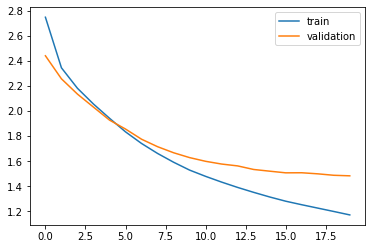

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Predicciones

In [ ]:
#model = load_model('model_rnn.h1')

In [ ]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'spanish': test[:,1],'english' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,spanish,english,predicted
0,le ha perdonado todo,she has forgiven him for everything,he has everything
1,me gustaría tener una respuesta,id like to have an answer,id like to answer
2,es seguro que él vendrá,he is sure to come,its sure he come
3,descubrimos ruinas de una civilización antigua,we discovered relics of an ancient civilization,we were a of found a born
4,soy soltero,i am single,im am
5,estaba muy cansado de manera que me fui temprano a la cama,i was very tired so i went to bed early,i was tired that i to bed
6,él es capaz de hablar diez lenguas,he is able to speak ten languages,he is able to languages
7,debiste haber venido más pronto,you should have come earlier,you must have be soon
8,me acuerdo diciéndotelo así,i remember telling you so,i remember that
9,¿necesitas el libro,do you need the book,do you need the book


In [ ]:
pred_df.tail(15)

,spanish,english,predicted
2444,trae el libro,get the book,give the book
2445,tom no parece estar muy cansado,tom doesnt seem to be very tired,tom doesnt be very
2446,voy a la escuela los sábados,i go to school on saturday,i go to school
2447,estoy esperando a que ella venga,im waiting for her to come here,im am waiting to her
2448,quiero aprender a disparar como tú,i want to learn to shoot like you,i want to learn you
2449,¿seguro que no quieres una taza de café,are you sure you dont want a cup of coffee,do you dont a cup coffee
2450,tom ha estado trabajando como traductor desde que se graduó de la universidad,tom has been working as a translator ever since he graduated from college,tom has been working a since he a
2451,ella anda,she walks,she is
2452,tengo que hacer un examen,i have to take an exam,i have to make a
2453,esta tarde hace muchísimo frío,its awfully cold this evening,this is very for cold


In [ ]:
pred_df.sample(15)

,spanish,english,predicted
334,tom vivió unos años en boston,tom lived in boston for a few years,tom lived in
523,¿acaso no fue él quien te robó la billetera,wasnt it him who stole your wallet,who was who
2112,ella estaba sorprendida de las noticias,she was surprised at the news,she was surprised at the
390,¿de qué están hablando,what are they talking about,what are you talking
1589,eso es bastante normal,thats pretty normal,thats quite
1631,ella cerró todas las ventanas en la habitación,she closed all the windows in the room,she sat her room
569,tom parecía estar algo decepcionado,tom seemed to be somewhat disappointed,tom seemed to be something
1786,¿quiénes son tus enemigos,who are your enemies,who are your
1107,llegó a casa exactamente a las diez,he came home right at ten,he arrived at when
1357,¿se pueden tomar fotos dentro de este edificio,is it all right to take pictures in this building,can should take borrow this
